# UNET for segmenting aggregates 

In [1]:
# U-ConvNet for segmentation of aggregates
print("""The script is a Python implementation of UConvNet for image segmentation. We provide a labeled training dataset
- images and corresponding masks - to train the neural net. The script makes use of MXNET library/APIs and the python libraries:
numpy, matplotlib, os and PIL\n
/**
 * @author :Ali Hashmi (with input from Alexey Golyshev)
 *
 *  code is based of the Architecture proposed by: "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/"
 */\n""");

The script is a Python implementation of UConvNet for image segmentation. We provide a labeled training dataset
- images and corresponding masks - to train the neural net. The script makes use of MXNET library/APIs and the python libraries:
numpy, matplotlib, os and PIL

/**
 * @author :Ali Hashmi (with input from Alexey Golyshev)
 *
 *  code is based of the Architecture proposed by: "https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/"
 */



# Library and Module Imports

In [17]:
############ importing all relevant modules ############
import mxnet as mx, os, numpy as np, matplotlib.pyplot as plt, cv2, logging, random,scipy, seaborn as sns
from PIL import Image
from shutil import copyfile
from unet import *
from imagefuncs import *
logging.getLogger().setLevel(logging.INFO) # log the training session
from collections import namedtuple

sns.set(style="white", palette="muted", color_codes=True)
Batch = namedtuple('Batch', ['data'])

# Context set to GPU

In [3]:
############ context ###################################
device_context = mx.gpu(0); """set device over which the training will be perfomed. use mx.cpu() for training over CPU cores, however,
the training over CPU will be considerably slower (3 hours on an 8 core machine) compared to 7 minutes on my GPU (640 CUDA cores).
Yes, the difference is astounding !""";

print("version of MXNET: ", mx.__version__ ," -> with context set to: ", device_context,"\n")

version of MXNET:  1.1.0  -> with context set to:  gpu(0) 



# Global parameter/hyperparams

In [4]:
############# global constants & HyperParamaters ###################
width,height = (160,160)    #images and masks will be resized according to the following tuple
filtercount = 64
directory = "C:\\Users\\aliha\\Downloads\\fabrice-ali\\deeplearning\\";
kernel_size = (3,3) #kernel size for convolutions
pad_size = (1,1) #padding for convolutions
initializer = mx.initializer.Normal(np.sqrt(2 / 576))
num_round = 10; #number of epochs (for training rounds)
batch_size = 8; #batch-size to process
fractionalp = 5/6; #training-dataset/testing-dataset ratio
lr = 0.01;  #learning rate
optimizer = 'adam' # other possible options are: 'adam', 'rmsprop', 'nadam' etc..
optimizerdict = {'learning_rate': lr}
train,retrain,applynet = (False,False,True)
# for retraining the network
(start_epoch,step_epochs) = (10,0)
save_round = start_epoch + step_epochs

# Creating dataset

In [26]:
############## setting directory #################
if(os.getcwd() != directory):
    os.chdir(directory)

training_image_directory = directory + "data\\train\\train_images_8bit\\";
imagefilenames = os.listdir(training_image_directory); # list of all images in the directory

training_label_directory = directory + "data\\train\\train_masks\\";
maskfilenames = os.listdir(training_label_directory); # list of all masks in the directory

In [27]:
###############  generate training and test datasets ###################

# load and resize labels -> ensure binary images
imagefilenames = list(map(lambda x: training_image_directory + x, imagefilenames))
maskfilenames = list(map(lambda x: training_label_directory + x, maskfilenames))
# considering a subset of data and corresponding labels
imagefilenames = imagefilenames[0:360]
maskfilenames = maskfilenames[0:360]

##### Resize images
train_x = np.asarray(list(map(lambda x: np.array(imageResize(x,width,height)), imagefilenames))) 

##### Resize Masks/Labels
train_y = np.asarray(list(map(lambda x: np.array(imageResize(x,width,height)),maskfilenames)))
train_y[train_y >= 1] = 1; # ensure binarization
train_y[train_y < 1] = 0;

# splitting datasets to training and testing halves
N = len(maskfilenames)
n = int(np.floor(N*fractionalp)) # adjust fractionalp to change the training/testing datasets lengths
print("length of training dataset:", n, " samples")
print("length of validation dataset:", N-n, " samples\n")

assert len(train_x) == len(train_y)
train_x = train_x.reshape((len(train_x),1,width,height)) # array reshaping required for data and labels
train_y = train_y.reshape((len(train_y),1,width,height))
train_x_array,test_x_array = (train_x[:n], train_x[n:])
train_y_array,test_y_array = (train_y[:n], train_y[n:])

length of training dataset: 300  samples
length of validation dataset: 60  samples



# Invoke Net and train 

In [7]:
#---------------------------------------- Learning Factory -----------------------------------------------
os.chdir(directory + "saved_models\\") # dir to save the training model

print("### Architecture of U-net ###\n")
######################## make the network ########################
net = get_unet(filtercount, kernel_size, pad_size, batch_size, width, height) # generate the symbolic network (uninitialized)
mx.viz.plot_network(net, save_format = 'pdf').render() # visualize the neural network -> check directory for save

# internal metrics can be used, in contrast build custom metrics if need-be
fig = plt.matshow(np.random.random((height,width)))

def custom_rmse(label,pred):
    return np.sqrt(np.mean((label-pred)**2))

def custom_logloss(label,pred):
    return np.mean((label*np.log(pred)) + ((1-label)*np.log(1-pred)))

metric_custom_rmse = mx.metric.CustomMetric(feval = custom_rmse)
#metric_internal = mx.metric.create(['acc','rmse'])
#metric_logloss_Custom = mx.metric.CustomMetric(feval = custom_logloss)
#rounded_mean_err = lambda labels, predictors : np.mean(np.abs(labels-np.round(predictors)))
#metric_rmse_Custom_rounded = mx.metric.CustomMetric(feval = rounded_mean_err)

train_iter = mx.io.NDArrayIter(train_x_array, train_y_array, batch_size, label_name = 'target', shuffle=True)
val_iter = mx.io.NDArrayIter(data = test_x_array, label = test_y_array, batch_size = batch_size, shuffle=True)

# training the network-model
if train:
    mod = mx.mod.Module(symbol=net, data_names=['data'], label_names=['target'], context=device_context)
    mod.bind(data_shapes= train_iter.provide_data, label_shapes= train_iter.provide_label)
    mod.fit(
        train_data = train_iter,
        #eval_data = val_iter,
        optimizer= optimizer,
        initializer = initializer,
        optimizer_params=optimizerdict,
        eval_metric = metric_custom_rmse,
        num_epoch = num_round
        )
    #print(model.score(val_iter,eval_metric = metric_custom_rmse))
    mod.save_checkpoint("blobseg_model", num_round)

    # saving the trained model
    destination = directory + "saved_models\\lg_saves\\iteration " + str(num_round) + "\\";
    if not os.path.exists(destination):
        os.makedirs(destination)
    filesToCopy = [fname for fname in os.listdir() if fname.startswith("blobseg_model")]
    [copyfile(os.getcwd() + "\\" + fname, destination + fname) for fname in filesToCopy]


### Architecture of U-net ###

@enc module_1:  [(8, 64, 160, 160)]
@enc module_2:  [(8, 128, 80, 80)]
@enc module_3:  [(8, 256, 40, 40)]
@enc module_4:  [(8, 512, 20, 20)]
@enc module_5:  [(8, 1024, 10, 10)]
@decoder_module_1:  [(8, 512, 20, 20)]
@decoder_module_2:  [(8, 256, 40, 40)]
@decoder_module_3:  [(8, 128, 80, 80)]
@decoder_module_4:  [(8, 64, 160, 160)]
@conv:  [(8, 1, 160, 160)]
@output:  [(8, 1, 160, 160)]




# Retrain Net if necessary

In [8]:
# --------------------------------------- Supplementary procedures ---------------------------------------------
############### retrain the network-model if necessary #################
if retrain:
    iteration = str(start_epoch)
    os.chdir(directory + "saved_models\\lg_saves\\iteration " + iteration)
    model_prefix = "blobseg_model"
    symbolicNet, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, start_epoch)
    model = mx.module.Module(symbol = symbolicNet,data_names=['data'],label_names=['target'],context = device_context)
    model.fit(
    train_data = train_iter,
    #eval_data = val_iter,
    arg_params = arg_params,
    aux_params = aux_params,
    optimizer = optimizer,
    num_epoch = step_epochs,
    optimizer_params = optimizerdict,
    eval_metric = metric_custom_rmse
    )
    # save the retrained net
    os.chdir(directory + "saved_models\\retrain\\")
    model.save_checkpoint(model_prefix,save_round)

# Apply Net given an image

printing last 10 NET-layers: ['batchnorm17_gamma', 'batchnorm17_beta', 'batchnorm17_moving_mean', 'batchnorm17_moving_var', 'batchnorm17_output', 'convolution18_weight', 'convolution18_bias', 'convolution18_output', 'target', 'logisticregressionoutput0_output'] 



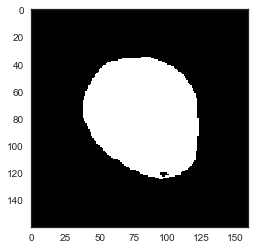

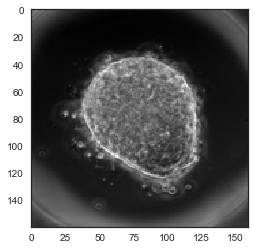

In [143]:
############### load the pretrained network and apply over an image ################
# testing data
randnum = np.random.randint(len(test_x_array))
if applynet:
    testimgdata = test_x_array[randnum].reshape((1,1,width,height)) # input data to the net    
    fe_mod = loadNet(directory + "saved_models\\lg_saves\\iteration ", num_round, "blobseg_model", device_context,width,height)
    fe_mod.forward(Batch([mx.nd.array(testimgdata)]))         # apply the net on the input image
    features = fe_mod.get_outputs()[0].asnumpy()        # output tensor
    features[features >= 0.1] = 255        # assign 255 (white)
    plt.imshow(features[0][0],cmap = "gray")
    plt.show()
    plt.imshow(test_x_array[randnum,0],cmap="gray")
    plt.show()
    mask = np.array(features[0][0],dtype='uint8')       # peal tensor to get the matrix
    maskimg = Image.fromarray(mask)        # create image and display
    maskimg.save("C:/Users/aliha/Desktop/segmentationOutput.tif") # save segmentation mask
    img = Image.fromarray(test_x_array[randnum,0])        # create image and display
    img.save("C:/Users/aliha/Desktop/image_test.tif") # save segmentation mask

# Checking error from ground truth 

printing last 10 NET-layers: ['batchnorm17_gamma', 'batchnorm17_beta', 'batchnorm17_moving_mean', 'batchnorm17_moving_var', 'batchnorm17_output', 'convolution18_weight', 'convolution18_bias', 'convolution18_output', 'target', 'logisticregressionoutput0_output'] 



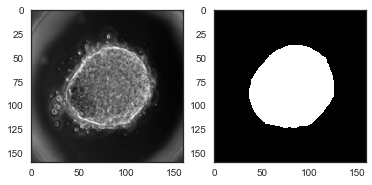

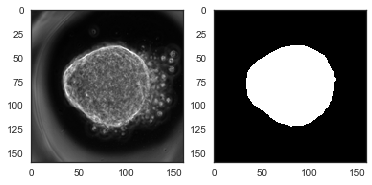

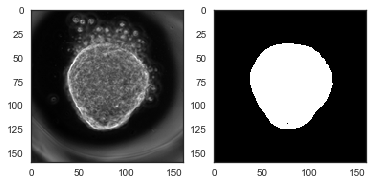

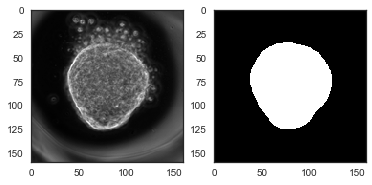

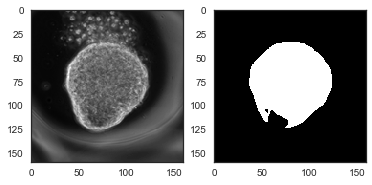

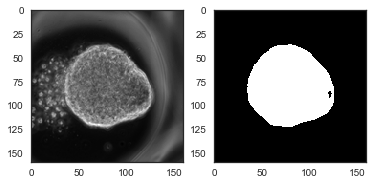

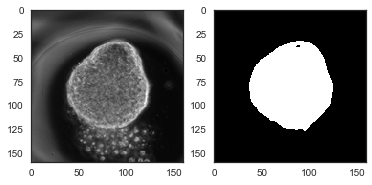

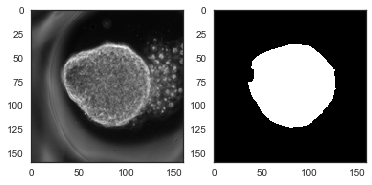

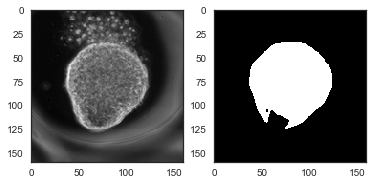

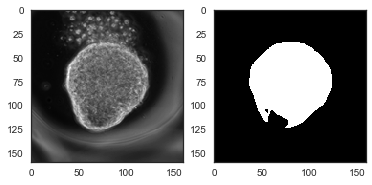

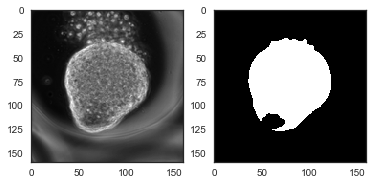

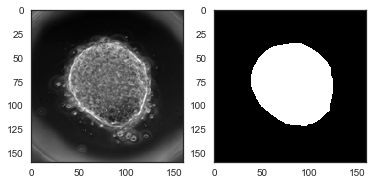

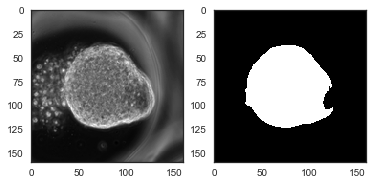

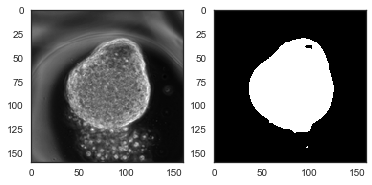

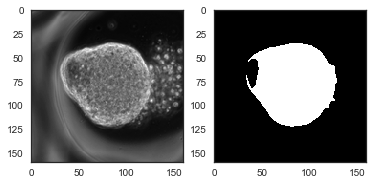

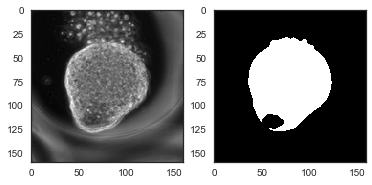

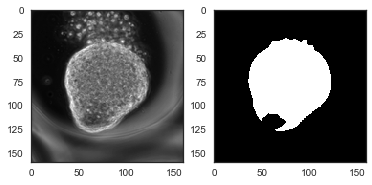

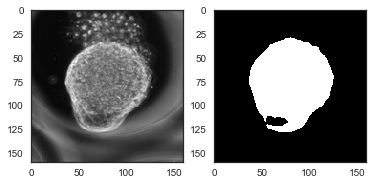

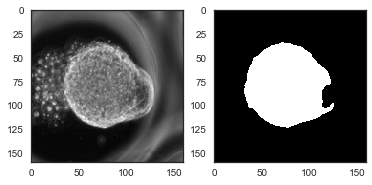

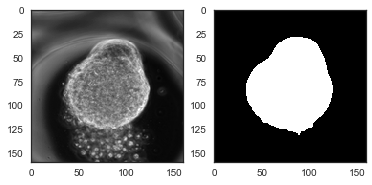

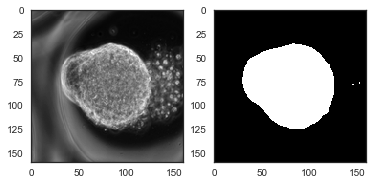

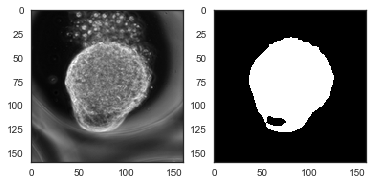

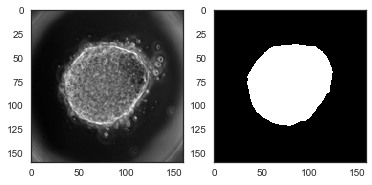

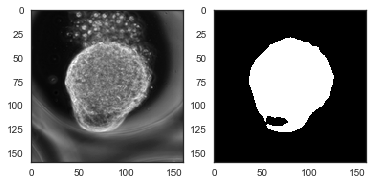

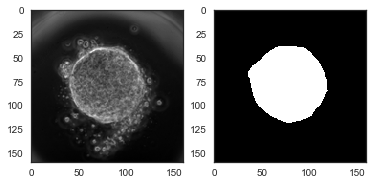

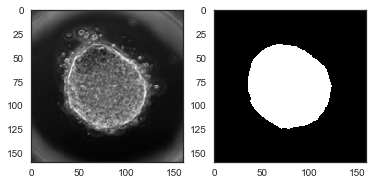

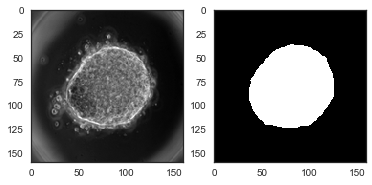

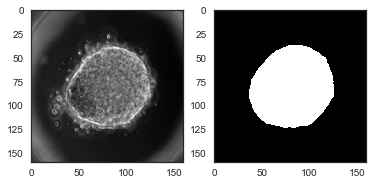

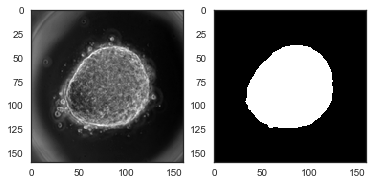

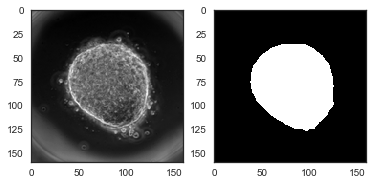

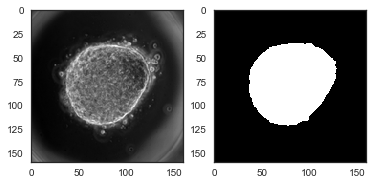

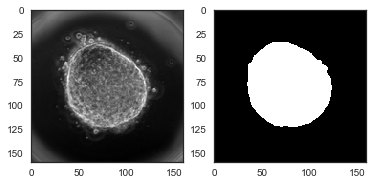

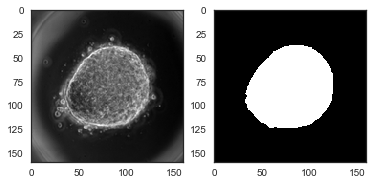

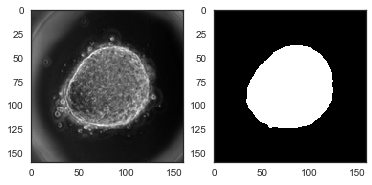

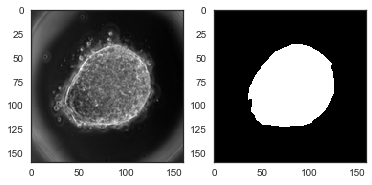

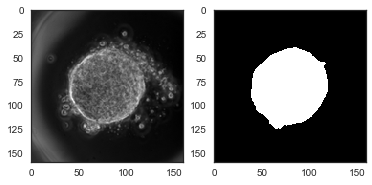

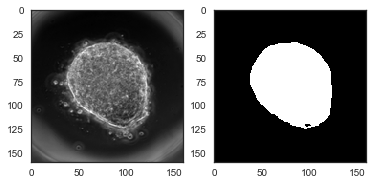

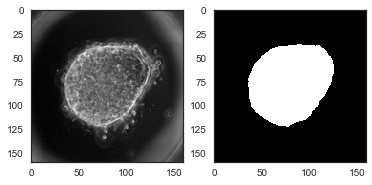

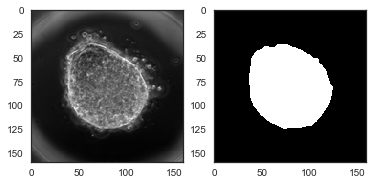

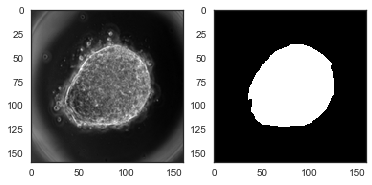

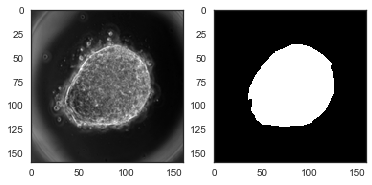

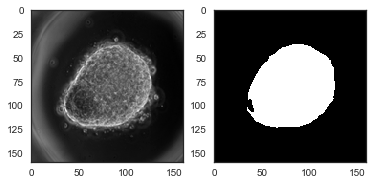

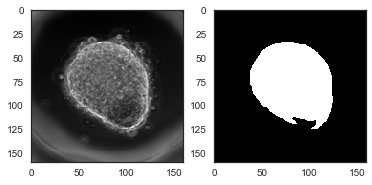

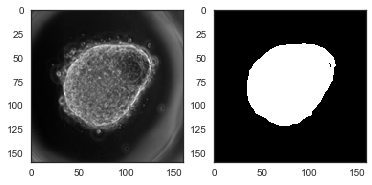

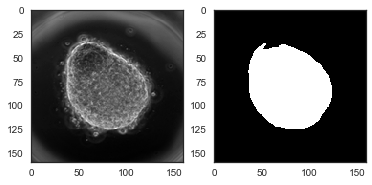

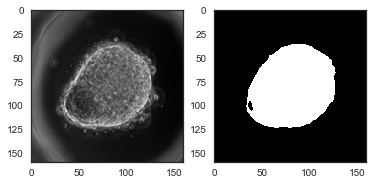

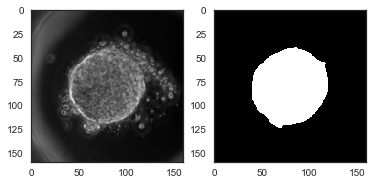

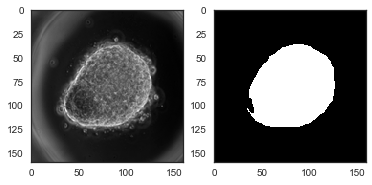

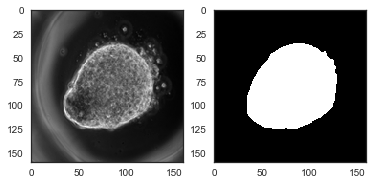

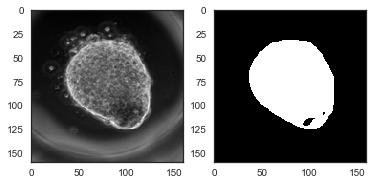

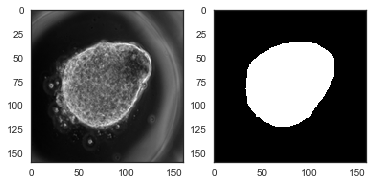

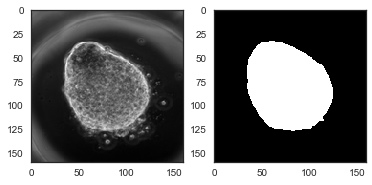

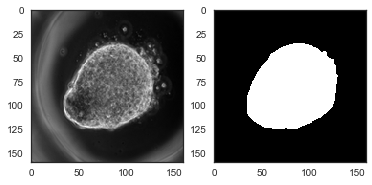

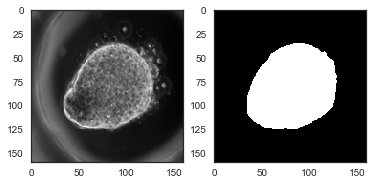

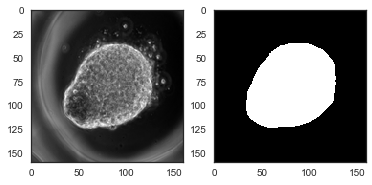

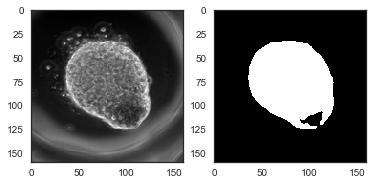

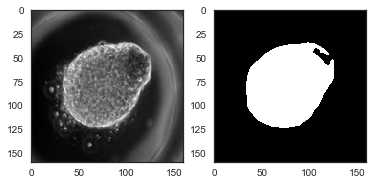

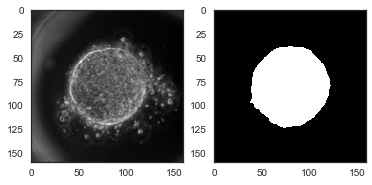

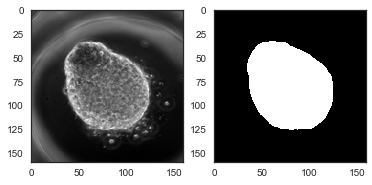

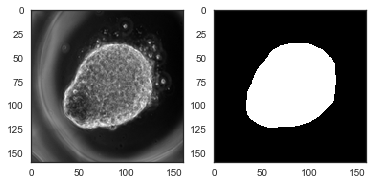

In [115]:
temp=[];
if applynet:
    fe_mod = loadNet(directory + "saved_models\\lg_saves\\iteration ", num_round, "blobseg_model", device_context, width, height)    
    for j,i in enumerate(test_x_array):
        groundT = test_y_array[j]*1
        groundT[groundT >= 1] = 1
        groundT[groundT < 1] = 0
        i = i.reshape((1,1,width,height))
        fe_mod.forward(Batch([mx.nd.array(i)]))            # apply the net on the input image
        features = fe_mod.get_outputs()[0].asnumpy()       # output tensor
        features[features >= 0.1] = 1
        features[features < 0.1] = 0
        temp.append(1.0 - scipy.spatial.distance.hamming(groundT.flatten(),features.flatten()))
        mask = np.array(features[0,0],dtype='uint8')       # peal tensor to get the matrix
        maskimg = Image.fromarray(mask)      # create mask image
        #maskimg.save("C:/Users/aliha/Desktop/output/mask/segmentationOutput" + str(j) + ".tif") # save segmentation mask
        img = np.array(test_x_array[j,0],dtype='uint8')       # peal tensor to get the matrix
        img = Image.fromarray(img)      # create image 
        #img.save("C:/Users/aliha/Desktop/output/image/serial" + str(j) + ".tif") # save image
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(test_x_array[j,0],cmap="gray")
        axarr[1].imshow(features[0,0],cmap= "gray")
        plt.show()

In [116]:
np.mean(temp)

0.9812044270833332

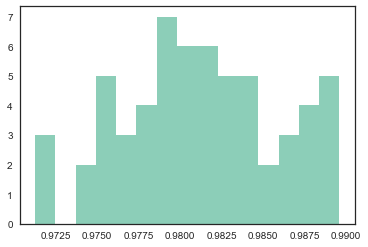

In [119]:
sns.distplot(temp, kde=False, color="#4CB391",bins=15)
plt.show()